In [97]:
import tensorflow_datasets as tfds
import tensorflow as tf
import os
import re
import time
import numpy as np
import matplotlib.pyplot as plt
import unicodedata
import io
import  nltk.translate.bleu_score as bleu
import pynlpir

In [2]:
# path_to_zip = tf.keras.utils.get_file(
#     'cornell_movie_dialogs.zip',
#     origin=
#     'http://www.cs.cornell.edu/~cristian/data/cornell_movie_dialogs_corpus.zip',
#     extract=True)

# path_to_dataset = os.path.join(
#     os.path.dirname(path_to_zip), "cornell movie-dialogs corpus")

# path_to_movie_lines = os.path.join(path_to_dataset, 'movie_lines.txt')
# path_to_movie_conversations = os.path.join(path_to_dataset,
#                                            'movie_conversations.txt')

In [3]:
path_to_zip = 'C:\\Users\\user\\Project From Alex NLP\\chi-eng.zip'
path_to_file = os.path.dirname(path_to_zip)+"\\chi-eng\\cmn.txt"
print(path_to_file)

C:\Users\user\Project From Alex NLP\chi-eng\cmn.txt


In [4]:
# Maximum number of samples to preprocess
# MAX_SAMPLES = 5000

def preprocess_sentence(sentence):
  sentence = sentence.lower().strip()
  # creating a space between a word and the punctuation following it
  # eg: "he is a boy." => "he is a boy ."
  sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
  sentence = re.sub(r'[" "]+', " ", sentence)
  # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",")
  sentence = re.sub(r"[^a-zA-Z?.!,]+", " ", sentence)
  sentence = sentence.strip()
  # adding a start and an end token to the sentence
  # so that the model know when to start and stop predicting.
#   sentence = '<start> ' + sentence + ' <end>'
  return sentence


# def load_conversations(num1,num2):
#   # dictionary of line id to text
#   id2line = {}
#   with open(path_to_movie_lines, errors='ignore') as file:
#     lines = file.readlines()
#   for line in lines:
#     parts = line.replace('\n', '').split(' +++$+++ ')
#     id2line[parts[0]] = parts[4]

#   inputs, outputs = [], []
#   with open(path_to_movie_conversations, 'r') as file:
#     lines = file.readlines()
#   for line in lines[num1:num2]:
#     parts = line.replace('\n', '').split(' +++$+++ ')
#     # get conversation in a list of line ID
#     conversation = [line[1:-1] for line in parts[3][1:-1].split(', ')]
#     for i in range(len(conversation) - 1):
#       inputs.append(preprocess_sentence(id2line[conversation[i]]))
#       outputs.append(preprocess_sentence(id2line[conversation[i + 1]]))
# #       if len(inputs) >= MAX_SAMPLES:
# #         return inputs, outputs
#   return inputs, outputs


# questions, answers = load_conversations(0,20000)

In [5]:
# len(questions),len(answers)

In [6]:
# questions_val, answers_val = load_conversations(80001,80500)

In [7]:
# len(questions_val),len(answers_val)

In [8]:
# print('Sample question: {}'.format(questions[20]))
# print('Sample answer: {}'.format(answers[20]))

In [9]:
def create_dataset(path, num1,num2):
  english = []
  chinese = []
  lines = io.open(path, encoding='UTF-8').read().strip().split('\n')

#   word_pairs = [[preprocess_sentence(w) for w in l.split('\t')]  for l in lines[:num_examples]]
  for l in lines[num1:num2]:
      eng = preprocess_sentence(l.split('\t')[0])
      chi = l.split('\t')[1]
      english.append(eng)
      chinese.append(chi)
        
  return english, chinese

In [10]:
en_tr, chi_tr = create_dataset(path_to_file, 0,20000)
print(en_tr[-1])
print(chi_tr[-1])

one man s meat is another man s poison .
甲之蜜糖，乙之砒霜。


In [11]:
len(en_tr),len(chi_tr)

(20000, 20000)

In [12]:
en_val, chi_val = create_dataset(path_to_file,23000,23500)
len(en_val),len(chi_val)

(500, 500)

In [13]:
# Build tokenizer using tfds for both questions and answers
tokenizer_en = tfds.features.text.SubwordTextEncoder.build_from_corpus(
    en_tr, target_vocab_size=2**13)

tokenizer_chi = tfds.features.text.SubwordTextEncoder.build_from_corpus(
    chi_tr, target_vocab_size=2**13)

# Build tokenizer using tfds for both questions and answers
# tokenizer = tfds.features.text.SubwordTextEncoder.build_from_corpus(
#     questions + answers, target_vocab_size=2**13)



In [14]:
# # Define start and end token to indicate the start and end of a sentence
# START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size + 1]

# # Vocabulary size plus start and end token
# VOCAB_SIZE = tokenizer.vocab_size + 2

In [15]:
sample_string = 'Transformer is awesome.'

tokenized_string = tokenizer_en.encode(sample_string)
print ('Tokenized string is {}'.format(tokenized_string))

original_string = tokenizer_en.decode(tokenized_string)
print ('The original string: {}'.format(original_string))

assert original_string == sample_string

Tokenized string is [7301, 5149, 7332, 6165, 8, 3017, 7263]
The original string: Transformer is awesome.


In [16]:
sample_string = en_tr[5000]

tokenized_string = tokenizer_en.encode(sample_string)
print ('Tokenized string is {}'.format(tokenized_string))

original_string = tokenizer_en.decode(tokenized_string)
print ('The original string: {}'.format(original_string))

assert original_string == sample_string

Tokenized string is [14, 567, 3, 990, 320, 1]
The original string: she hit the ball hard .


In [17]:
for ts in tokenized_string:
  print ('{} ----> {}'.format(ts, tokenizer_en.decode([ts])))

14 ----> she 
567 ----> hit 
3 ----> the 
990 ----> ball 
320 ----> hard
1 ---->  .


In [18]:
sample_string = '很高興認識你'
tokenized_string = tokenizer_chi.encode(sample_string)
for ts in tokenized_string:
  print ('{} ----> {}'.format(ts, tokenizer_chi.decode([ts])))

4573 ----> 很高興
575 ----> 認識
9 ----> 你


In [19]:
BUFFER_SIZE = 20000
BATCH_SIZE = 64

In [20]:
def encode(lang1, lang2):
  lang1 = [tokenizer_en.vocab_size] + tokenizer_en.encode(
      lang1.numpy()) + [tokenizer_en.vocab_size+1]

  lang2 = [tokenizer_chi.vocab_size] + tokenizer_chi.encode(
      lang2.numpy()) + [tokenizer_chi.vocab_size+1]
  
  return lang1, lang2

In [21]:
def tf_encode(en, chi):
  result_en, result_chi = tf.py_function(encode, [en, chi], [tf.int64, tf.int64])
  result_en.set_shape([None])
  result_chi.set_shape([None])

  return result_en, result_chi

In [22]:
MAX_LENGTH = 40

In [23]:
def filter_max_length(x, y, max_length=MAX_LENGTH):
  return tf.logical_and(tf.size(x) <= max_length,
                        tf.size(y) <= max_length)

In [24]:
train_preprocessed = (
    tf.data.Dataset.from_tensor_slices((en_tr, chi_tr))
    .map(tf_encode) 
    .filter(filter_max_length)
    # cache the dataset to memory to get a speedup while reading from it.
    .cache()
    .shuffle(BUFFER_SIZE))

# val_preprocessed = (
#     tf.data.Dataset.from_tensor_slices((questions_val, answers_val))
#     .map(tf_encode)
#     .filter(filter_max_length))     

In [25]:
train_dataset = (train_preprocessed
                 .padded_batch(BATCH_SIZE, padded_shapes=([None], [None]))
                 .prefetch(tf.data.experimental.AUTOTUNE))

# val_dataset = (val_preprocessed
#                .padded_batch(BATCH_SIZE,  padded_shapes=([None], [None])))

In [26]:
# print('Tokenized sample question: {}'.format(tokenizer_ques.encode(questions[20])))

In [27]:
# # Maximum sentence length
# MAX_LENGTH = 40


# # Tokenize, filter and pad sentences
# def tokenize_and_filter(inputs, outputs):
#   tokenized_inputs, tokenized_outputs = [], []
  
#   for (sentence1, sentence2) in zip(inputs, outputs):
#     # tokenize sentence
#     sentence1 = [tokenizer_ques.vocab_size] + tokenizer_ques.encode(sentence1) + [tokenizer_ques.vocab_size + 1]
#     sentence2 = [tokenizer_ans.vocab_size] + tokenizer_ans.encode(sentence2) + [tokenizer_ans.vocab_size + 1]
#     # check tokenized sentence max length
#     if len(sentence1) <= MAX_LENGTH and len(sentence2) <= MAX_LENGTH:
#       tokenized_inputs.append(sentence1)
#       tokenized_outputs.append(sentence2)
  
#   # pad tokenized sentences
#   tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(
#       tokenized_inputs, maxlen=MAX_LENGTH, padding='post')
#   tokenized_outputs = tf.keras.preprocessing.sequence.pad_sequences(
#       tokenized_outputs, maxlen=MAX_LENGTH, padding='post')
  
#   return tokenized_inputs, tokenized_outputs


# questions, answers = tokenize_and_filter(questions, answers)

In [28]:
# questions[20]

In [29]:
# answers[20]

In [30]:
# print('Vocab size: {}'.format(VOCAB_SIZE))
# print('Number of samples: {}'.format(len(questions)))

In [31]:
# BATCH_SIZE = 64
# BUFFER_SIZE = 20000

# # decoder inputs use the previous target as input
# # remove START_TOKEN from targets
# # dataset = tf.data.Dataset.from_tensor_slices((
# #     {
# #         'inputs': questions
# #         #'dec_inputs': answers[:, :-1]
# #     },
# #     {
# #         'outputs': answers
# #     },
# # ))
# dataset = tf.data.Dataset.from_tensor_slices((questions, answers))
# dataset = dataset.cache()
# dataset = dataset.shuffle(BUFFER_SIZE)
# dataset = dataset.batch(BATCH_SIZE)
# dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

In [32]:
print(train_dataset)

<PrefetchDataset shapes: ((None, None), (None, None)), types: (tf.int64, tf.int64)>


In [33]:
en_batch, chi_batch = next(iter(train_dataset))
en_batch

<tf.Tensor: shape=(64, 12), dtype=int64, numpy=
array([[7473,    3, 1728,    8,   35,    3, 3190,  545,    1, 7474,    0,
           0],
       [7473,  112,   30,  105,    4,  875,    1, 7474,    0,    0,    0,
           0],
       [7473,    8,   11, 1220,    6, 7474,    0,    0,    0,    0,    0,
           0],
       [7473,   76,   18,    5,   43,    4,  168,    6, 7474,    0,    0,
           0],
       [7473,    2,   46,   37,  260,  115,    1, 7474,    0,    0,    0,
           0],
       [7473,   28,    5,  488,   30,   25,  580,    6, 7474,    0,    0,
           0],
       [7473,   29,    5,  625,  329,   77,    6, 7474,    0,    0,    0,
           0],
       [7473,   34, 1412,   32,   16,  474,    4,  538,    1, 7474,    0,
           0],
       [7473,   11,   12,  352,    1, 7474,    0,    0,    0,    0,    0,
           0],
       [7473,   21,   54,  164,  456, 1528,    1, 7474,    0,    0,    0,
           0],
       [7473,   76,   51,    5,   49,   26,    3, 1073,    6, 

In [34]:
chi_batch

<tf.Tensor: shape=(64, 16), dtype=int64, numpy=
array([[7318, 6446,  416, ...,    0,    0,    0],
       [7318,  556, 1004, ...,    0,    0,    0],
       [7318,  192, 3705, ...,    0,    0,    0],
       ...,
       [7318, 2092,  335, ...,    0,    0,    0],
       [7318, 3530, 2674, ...,    0,    0,    0],
       [7318,   11, 5410, ...,    0,    0,    0]], dtype=int64)>

# Positional Encoding 

In [35]:
def get_angles(pos, i, d_model):
  angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
  return pos * angle_rates

In [36]:
def positional_encoding(position, d_model):
  angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                          np.arange(d_model)[np.newaxis, :],
                          d_model)
  
  # apply sin to even indices in the array; 2i
  angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
  
  # apply cos to odd indices in the array; 2i+1
  angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
    
  pos_encoding = angle_rads[np.newaxis, ...]
    
  return tf.cast(pos_encoding, dtype=tf.float32)

(1, 50, 512)


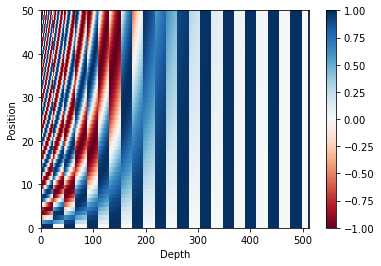

In [37]:
pos_encoding = positional_encoding(50, 512)
print (pos_encoding.shape)

plt.pcolormesh(pos_encoding[0], cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0, 512))
plt.ylabel('Position')
plt.colorbar()
plt.show()

# Masking

In [38]:
def create_padding_mask(seq):
  seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
  
  # add extra dimensions to add the padding
  # to the attention logits.
  return seq[:, tf.newaxis, tf.newaxis, :]  # (batch_size, 1, 1, seq_len)

In [39]:
x = tf.constant([[7, 6, 0, 0, 1], [1, 2, 3, 0, 0], [0, 0, 0, 4, 5]])
create_padding_mask(x)

<tf.Tensor: shape=(3, 1, 1, 5), dtype=float32, numpy=
array([[[[0., 0., 1., 1., 0.]]],


       [[[0., 0., 0., 1., 1.]]],


       [[[1., 1., 1., 0., 0.]]]], dtype=float32)>

In [40]:
def create_look_ahead_mask(size):
  mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
  return mask  # (seq_len, seq_len)

In [41]:
x = tf.random.uniform((1, 3))
temp = create_look_ahead_mask(x.shape[1])
temp

<tf.Tensor: shape=(3, 3), dtype=float32, numpy=
array([[0., 1., 1.],
       [0., 0., 1.],
       [0., 0., 0.]], dtype=float32)>

# Scaled Dot Product Attention

In [42]:
def scaled_dot_product_attention(q, k, v, mask):
  """Calculate the attention weights.
  q, k, v must have matching leading dimensions.
  k, v must have matching penultimate dimension, i.e.: seq_len_k = seq_len_v.
  The mask has different shapes depending on its type(padding or look ahead) 
  but it must be broadcastable for addition.
  
  Args:
    q: query shape == (..., seq_len_q, depth)
    k: key shape == (..., seq_len_k, depth)
    v: value shape == (..., seq_len_v, depth_v)
    mask: Float tensor with shape broadcastable 
          to (..., seq_len_q, seq_len_k). Defaults to None.
    
  Returns:
    output, attention_weights
  """

  matmul_qk = tf.matmul(q, k, transpose_b=True)  # (..., seq_len_q, seq_len_k)
  
  # scale matmul_qk
  dk = tf.cast(tf.shape(k)[-1], tf.float32)
  scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

  # add the mask to the scaled tensor.
  if mask is not None:
    scaled_attention_logits += (mask * -1e9)  

  # softmax is normalized on the last axis (seq_len_k) so that the scores
  # add up to 1.
  attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)  # (..., seq_len_q, seq_len_k)

  output = tf.matmul(attention_weights, v)  # (..., seq_len_q, depth_v)

  return output, attention_weights

In [43]:
def print_out(q, k, v):
  temp_out, temp_attn = scaled_dot_product_attention(
      q, k, v, None)
  print ('Attention weights are:')
  print (temp_attn)
  print ('Output is:')
  print (temp_out)

In [44]:
np.set_printoptions(suppress=True)

temp_k = tf.constant([[10,0,0],
                      [0,10,0],
                      [0,0,10],
                      [0,0,10]], dtype=tf.float32)  # (4, 3)

temp_v = tf.constant([[   1,0],
                      [  10,0],
                      [ 100,5],
                      [1000,6]], dtype=tf.float32)  # (4, 2)

# This `query` aligns with the second `key`,
# so the second `value` is returned.
temp_q = tf.constant([[0, 10, 0]], dtype=tf.float32)  # (1, 3)
print_out(temp_q, temp_k, temp_v)

Attention weights are:
tf.Tensor([[0. 1. 0. 0.]], shape=(1, 4), dtype=float32)
Output is:
tf.Tensor([[10.  0.]], shape=(1, 2), dtype=float32)


In [45]:
# This query aligns with a repeated key (third and fourth), 
# so all associated values get averaged.
temp_q = tf.constant([[0, 0, 10]], dtype=tf.float32)  # (1, 3)
print_out(temp_q, temp_k, temp_v)

Attention weights are:
tf.Tensor([[0.  0.  0.5 0.5]], shape=(1, 4), dtype=float32)
Output is:
tf.Tensor([[550.    5.5]], shape=(1, 2), dtype=float32)


In [46]:
# This query aligns equally with the first and second key, 
# so their values get averaged.
temp_q = tf.constant([[10, 10, 0]], dtype=tf.float32)  # (1, 3)
print_out(temp_q, temp_k, temp_v)

Attention weights are:
tf.Tensor([[0.5 0.5 0.  0. ]], shape=(1, 4), dtype=float32)
Output is:
tf.Tensor([[5.5 0. ]], shape=(1, 2), dtype=float32)


In [47]:
temp_q = tf.constant([[0, 0, 10], [0, 10, 0], [10, 10, 0]], dtype=tf.float32)  # (3, 3)
print_out(temp_q, temp_k, temp_v)

Attention weights are:
tf.Tensor(
[[0.  0.  0.5 0.5]
 [0.  1.  0.  0. ]
 [0.5 0.5 0.  0. ]], shape=(3, 4), dtype=float32)
Output is:
tf.Tensor(
[[550.    5.5]
 [ 10.    0. ]
 [  5.5   0. ]], shape=(3, 2), dtype=float32)


# Multi-head attention

In [48]:
class MultiHeadAttention(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads):
    super(MultiHeadAttention, self).__init__()
    self.num_heads = num_heads
    self.d_model = d_model
    
    assert d_model % self.num_heads == 0
    
    self.depth = d_model // self.num_heads
    
    self.wq = tf.keras.layers.Dense(d_model)
    self.wk = tf.keras.layers.Dense(d_model)
    self.wv = tf.keras.layers.Dense(d_model)
    
    self.dense = tf.keras.layers.Dense(d_model)
        
  def split_heads(self, x, batch_size):
    """Split the last dimension into (num_heads, depth).
    Transpose the result such that the shape is (batch_size, num_heads, seq_len, depth)
    """
    x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(x, perm=[0, 2, 1, 3])
    
  def call(self, v, k, q, mask):
    batch_size = tf.shape(q)[0]
    
    q = self.wq(q)  # (batch_size, seq_len, d_model)
    k = self.wk(k)  # (batch_size, seq_len, d_model)
    v = self.wv(v)  # (batch_size, seq_len, d_model)
    
    q = self.split_heads(q, batch_size)  # (batch_size, num_heads, seq_len_q, depth)
    k = self.split_heads(k, batch_size)  # (batch_size, num_heads, seq_len_k, depth)
    v = self.split_heads(v, batch_size)  # (batch_size, num_heads, seq_len_v, depth)
    
    # scaled_attention.shape == (batch_size, num_heads, seq_len_q, depth)
    # attention_weights.shape == (batch_size, num_heads, seq_len_q, seq_len_k)
    scaled_attention, attention_weights = scaled_dot_product_attention(
        q, k, v, mask)
    
    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])  # (batch_size, seq_len_q, num_heads, depth)

    concat_attention = tf.reshape(scaled_attention, 
                                  (batch_size, -1, self.d_model))  # (batch_size, seq_len_q, d_model)

    output = self.dense(concat_attention)  # (batch_size, seq_len_q, d_model)
        
    return output, attention_weights

In [49]:
temp_mha = MultiHeadAttention(d_model=512, num_heads=8)
y = tf.random.uniform((1, 60, 512))  # (batch_size, encoder_sequence, d_model)
out, attn = temp_mha(y, k=y, q=y, mask=None)
out.shape, attn.shape

(TensorShape([1, 60, 512]), TensorShape([1, 8, 60, 60]))

# Point Wise Feed Forward Network

In [50]:
def point_wise_feed_forward_network(d_model, dff):
  return tf.keras.Sequential([
      tf.keras.layers.Dense(dff, activation='relu'),  # (batch_size, seq_len, dff)
      tf.keras.layers.Dense(d_model)  # (batch_size, seq_len, d_model)
  ])

In [51]:
sample_ffn = point_wise_feed_forward_network(512, 2048)
sample_ffn(tf.random.uniform((64, 50, 512))).shape

TensorShape([64, 50, 512])

# Encoder and Decoder

In [52]:
class EncoderLayer(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads, dff, rate=0.1):
    super(EncoderLayer, self).__init__()

    self.mha = MultiHeadAttention(d_model, num_heads)
    self.ffn = point_wise_feed_forward_network(d_model, dff)

    self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    
    self.dropout1 = tf.keras.layers.Dropout(rate)
    self.dropout2 = tf.keras.layers.Dropout(rate)
    
  def call(self, x, training, mask):

    attn_output, _ = self.mha(x, x, x, mask)  # (batch_size, input_seq_len, d_model)
    attn_output = self.dropout1(attn_output, training=training)
    out1 = self.layernorm1(x + attn_output)  # (batch_size, input_seq_len, d_model)
    
    ffn_output = self.ffn(out1)  # (batch_size, input_seq_len, d_model)
    ffn_output = self.dropout2(ffn_output, training=training)
    out2 = self.layernorm2(out1 + ffn_output)  # (batch_size, input_seq_len, d_model)
    
    return out2

In [53]:
sample_encoder_layer = EncoderLayer(512, 8, 2048)

sample_encoder_layer_output = sample_encoder_layer(
    tf.random.uniform((64, 43, 512)), False, None)

sample_encoder_layer_output.shape  # (batch_size, input_seq_len, d_model)

TensorShape([64, 43, 512])

In [54]:
class DecoderLayer(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads, dff, rate=0.1):
    super(DecoderLayer, self).__init__()

    self.mha1 = MultiHeadAttention(d_model, num_heads)
    self.mha2 = MultiHeadAttention(d_model, num_heads)

    self.ffn = point_wise_feed_forward_network(d_model, dff)
 
    self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    
    self.dropout1 = tf.keras.layers.Dropout(rate)
    self.dropout2 = tf.keras.layers.Dropout(rate)
    self.dropout3 = tf.keras.layers.Dropout(rate)
    
    
  def call(self, x, enc_output, training, 
           look_ahead_mask, padding_mask):
    # enc_output.shape == (batch_size, input_seq_len, d_model)

    attn1, attn_weights_block1 = self.mha1(x, x, x, look_ahead_mask)  # (batch_size, target_seq_len, d_model)
    attn1 = self.dropout1(attn1, training=training)
    out1 = self.layernorm1(attn1 + x)
    
    attn2, attn_weights_block2 = self.mha2(
        enc_output, enc_output, out1, padding_mask)  # (batch_size, target_seq_len, d_model)
    attn2 = self.dropout2(attn2, training=training)
    out2 = self.layernorm2(attn2 + out1)  # (batch_size, target_seq_len, d_model)
    
    ffn_output = self.ffn(out2)  # (batch_size, target_seq_len, d_model)
    ffn_output = self.dropout3(ffn_output, training=training)
    out3 = self.layernorm3(ffn_output + out2)  # (batch_size, target_seq_len, d_model)
    
    return out3, attn_weights_block1, attn_weights_block2

In [55]:
sample_decoder_layer = DecoderLayer(512, 8, 2048)

sample_decoder_layer_output, _, _ = sample_decoder_layer(
    tf.random.uniform((64, 50, 512)), sample_encoder_layer_output, 
    False, None, None)

sample_decoder_layer_output.shape  # (batch_size, target_seq_len, d_model)

TensorShape([64, 50, 512])

# Encoder

In [56]:
class Encoder(tf.keras.layers.Layer):
  def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size,
               maximum_position_encoding, rate=0.1):
    super(Encoder, self).__init__()

    self.d_model = d_model
    self.num_layers = num_layers
    
    self.embedding = tf.keras.layers.Embedding(input_vocab_size, d_model)
    self.pos_encoding = positional_encoding(maximum_position_encoding, 
                                            self.d_model)
    
    
    self.enc_layers = [EncoderLayer(d_model, num_heads, dff, rate) 
                       for _ in range(num_layers)]
  
    self.dropout = tf.keras.layers.Dropout(rate)
        
  def call(self, x, training, mask):

    seq_len = tf.shape(x)[1]
    
    # adding embedding and position encoding.
    x = self.embedding(x)  # (batch_size, input_seq_len, d_model)
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x += self.pos_encoding[:, :seq_len, :]

    x = self.dropout(x, training=training)
    
    for i in range(self.num_layers):
      x = self.enc_layers[i](x, training, mask)
    
    return x  # (batch_size, input_seq_len, d_model)

In [57]:
sample_encoder = Encoder(num_layers=2, d_model=512, num_heads=8, 
                         dff=2048, input_vocab_size=8500,
                         maximum_position_encoding=10000)
temp_input = tf.random.uniform((64, 62), dtype=tf.int64, minval=0, maxval=200)

sample_encoder_output = sample_encoder(temp_input, training=False, mask=None)

print (sample_encoder_output.shape)  # (batch_size, input_seq_len, d_model)

(64, 62, 512)


# Decoder

In [58]:
class Decoder(tf.keras.layers.Layer):
  def __init__(self, num_layers, d_model, num_heads, dff, target_vocab_size,
               maximum_position_encoding, rate=0.1):
    super(Decoder, self).__init__()

    self.d_model = d_model
    self.num_layers = num_layers
    
    self.embedding = tf.keras.layers.Embedding(target_vocab_size, d_model)
    self.pos_encoding = positional_encoding(maximum_position_encoding, d_model)
    
    self.dec_layers = [DecoderLayer(d_model, num_heads, dff, rate) 
                       for _ in range(num_layers)]
    self.dropout = tf.keras.layers.Dropout(rate)
    
  def call(self, x, enc_output, training, 
           look_ahead_mask, padding_mask):

    seq_len = tf.shape(x)[1]
    attention_weights = {}
    
    x = self.embedding(x)  # (batch_size, target_seq_len, d_model)
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x += self.pos_encoding[:, :seq_len, :]
    
    x = self.dropout(x, training=training)

    for i in range(self.num_layers):
      x, block1, block2 = self.dec_layers[i](x, enc_output, training,
                                             look_ahead_mask, padding_mask)
      
      attention_weights['decoder_layer{}_block1'.format(i+1)] = block1
      attention_weights['decoder_layer{}_block2'.format(i+1)] = block2
    
    # x.shape == (batch_size, target_seq_len, d_model)
    return x, attention_weights

In [59]:
sample_decoder = Decoder(num_layers=2, d_model=512, num_heads=8, 
                         dff=2048, target_vocab_size=8000,
                         maximum_position_encoding=5000)
temp_input = tf.random.uniform((64, 26), dtype=tf.int64, minval=0, maxval=200)

output, attn = sample_decoder(temp_input, 
                              enc_output=sample_encoder_output, 
                              training=False,
                              look_ahead_mask=None, 
                              padding_mask=None)

output.shape, attn['decoder_layer2_block2'].shape

(TensorShape([64, 26, 512]), TensorShape([64, 8, 26, 62]))

# Create The Transformer

In [60]:
class Transformer(tf.keras.Model):
  def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size, 
               target_vocab_size, pe_input, pe_target, rate=0.1):
    super(Transformer, self).__init__()

    self.encoder = Encoder(num_layers, d_model, num_heads, dff, 
                           input_vocab_size, pe_input, rate)

    self.decoder = Decoder(num_layers, d_model, num_heads, dff, 
                           target_vocab_size, pe_target, rate)

    self.final_layer = tf.keras.layers.Dense(target_vocab_size)
    
  def call(self, inp, tar, training, enc_padding_mask, 
           look_ahead_mask, dec_padding_mask):

    enc_output = self.encoder(inp, training, enc_padding_mask)  # (batch_size, inp_seq_len, d_model)
    
    # dec_output.shape == (batch_size, tar_seq_len, d_model)
    dec_output, attention_weights = self.decoder(
        tar, enc_output, training, look_ahead_mask, dec_padding_mask)
    
    final_output = self.final_layer(dec_output)  # (batch_size, tar_seq_len, target_vocab_size)
    
    return final_output, attention_weights

In [61]:
sample_transformer = Transformer(
    num_layers=2, d_model=512, num_heads=8, dff=2048, 
    input_vocab_size=8500, target_vocab_size=8000, 
    pe_input=10000, pe_target=6000)

temp_input = tf.random.uniform((64, 38), dtype=tf.int64, minval=0, maxval=200)
temp_target = tf.random.uniform((64, 36), dtype=tf.int64, minval=0, maxval=200)

fn_out, _ = sample_transformer(temp_input, temp_target, training=False, 
                               enc_padding_mask=None, 
                               look_ahead_mask=None,
                               dec_padding_mask=None)

fn_out.shape  # (batch_size, tar_seq_len, target_vocab_size)

TensorShape([64, 36, 8000])

# Set Hyperparameters

In [64]:
num_layers = 6
d_model = 512
dff = 1024
num_heads = 8

input_vocab_size = tokenizer_en.vocab_size + 2 #questions.vocab_size #+ 2
target_vocab_size = tokenizer_chi.vocab_size + 2 #answers.vocab_size #+ 2
dropout_rate = 0.1

# Optimizer

In [65]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, d_model, warmup_steps=4000):
    super(CustomSchedule, self).__init__()
    
    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps
    
  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)
    
    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [66]:
learning_rate = CustomSchedule(d_model)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, 
                                     epsilon=1e-9)

Text(0.5, 0, 'Train Step')

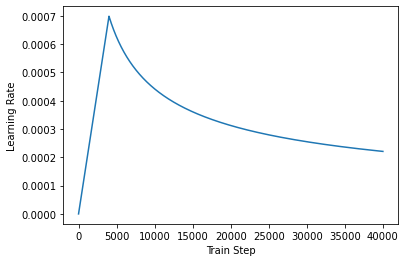

In [67]:
temp_learning_rate_schedule = CustomSchedule(d_model)

plt.plot(temp_learning_rate_schedule(tf.range(40000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

# Loss and Metrics

In [68]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

In [69]:
def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask
  
  return tf.reduce_sum(loss_)/tf.reduce_sum(mask)

In [70]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(
    name='train_accuracy')

# Training and Checkpointing

In [71]:
transformer = Transformer(num_layers, d_model, num_heads, dff,
                          input_vocab_size, target_vocab_size, 
                          pe_input=input_vocab_size, 
                          pe_target=target_vocab_size,
                          rate=dropout_rate)

In [72]:
def create_masks(inp, tar):
  # Encoder padding mask
  enc_padding_mask = create_padding_mask(inp)
  
  # Used in the 2nd attention block in the decoder.
  # This padding mask is used to mask the encoder outputs.
  dec_padding_mask = create_padding_mask(inp)
  
  # Used in the 1st attention block in the decoder.
  # It is used to pad and mask future tokens in the input received by 
  # the decoder.
  look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
  dec_target_padding_mask = create_padding_mask(tar)
  combined_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)
  
  return enc_padding_mask, combined_mask, dec_padding_mask

In [73]:
checkpoint_path = "./checkpoints/train_nmt_eng_to_chi_transformer"

ckpt = tf.train.Checkpoint(transformer=transformer,
                           optimizer=optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
  ckpt.restore(ckpt_manager.latest_checkpoint)
  print ('Latest checkpoint restored!!')

In [74]:
EPOCHS = 20

In [75]:
# The @tf.function trace-compiles train_step into a TF graph for faster
# execution. The function specializes to the precise shape of the argument
# tensors. To avoid re-tracing due to the variable sequence lengths or variable
# batch sizes (the last batch is smaller), use input_signature to specify
# more generic shapes.

train_step_signature = [
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
]

@tf.function(input_signature=train_step_signature)
def train_step(inp, tar):
  tar_inp = tar[:, :-1]
  tar_real = tar[:, 1:]
  
  enc_padding_mask, combined_mask, dec_padding_mask = create_masks(inp, tar_inp)
  
  with tf.GradientTape() as tape:
    predictions, _ = transformer(inp, tar_inp, 
                                 True, 
                                 enc_padding_mask, 
                                 combined_mask, 
                                 dec_padding_mask)
    loss = loss_function(tar_real, predictions)

  gradients = tape.gradient(loss, transformer.trainable_variables)    
  optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))
  
  train_loss(loss)
  train_accuracy(tar_real, predictions)

In [76]:
for epoch in range(EPOCHS):
  start = time.time()
  
  train_loss.reset_states()
  train_accuracy.reset_states()
  
  # inp -> portuguese, tar -> english
  for (batch, (inp, tar)) in enumerate(train_dataset):
    train_step(inp, tar)
    
    if batch % 50 == 0:
      print ('Epoch {} Batch {} Loss {:.4f} Accuracy {:.4f}'.format(
          epoch + 1, batch, train_loss.result(), train_accuracy.result()))
      
  if (epoch + 1) % 5 == 0:
    ckpt_save_path = ckpt_manager.save()
    print ('Saving checkpoint for epoch {} at {}'.format(epoch+1,
                                                         ckpt_save_path))
    
  print ('Epoch {} Loss {:.4f} Accuracy {:.4f}'.format(epoch + 1, 
                                                train_loss.result(), 
                                                train_accuracy.result()))

  print ('Time taken for 1 epoch: {} secs\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 8.9457 Accuracy 0.0000
Epoch 1 Batch 50 Loss 8.4793 Accuracy 0.0415
Epoch 1 Batch 100 Loss 8.0287 Accuracy 0.0567
Epoch 1 Batch 150 Loss 7.7569 Accuracy 0.0620
Epoch 1 Batch 200 Loss 7.5355 Accuracy 0.0721
Epoch 1 Batch 250 Loss 7.3073 Accuracy 0.0848
Epoch 1 Batch 300 Loss 7.1177 Accuracy 0.0940
Epoch 1 Loss 7.0772 Accuracy 0.0958
Time taken for 1 epoch: 52.03844618797302 secs

Epoch 2 Batch 0 Loss 6.0697 Accuracy 0.1373
Epoch 2 Batch 50 Loss 5.9851 Accuracy 0.1421
Epoch 2 Batch 100 Loss 5.9583 Accuracy 0.1395
Epoch 2 Batch 150 Loss 5.9333 Accuracy 0.1408
Epoch 2 Batch 200 Loss 5.9039 Accuracy 0.1399
Epoch 2 Batch 250 Loss 5.8720 Accuracy 0.1412
Epoch 2 Batch 300 Loss 5.8424 Accuracy 0.1429
Epoch 2 Loss 5.8327 Accuracy 0.1435
Time taken for 1 epoch: 32.710439920425415 secs

Epoch 3 Batch 0 Loss 5.5593 Accuracy 0.1302
Epoch 3 Batch 50 Loss 5.5723 Accuracy 0.1392
Epoch 3 Batch 100 Loss 5.5505 Accuracy 0.1458
Epoch 3 Batch 150 Loss 5.5334 Accuracy 0.1463
Epoch 3 Batc

Epoch 20 Batch 250 Loss 2.4154 Accuracy 0.2265
Epoch 20 Batch 300 Loss 2.4474 Accuracy 0.2232
Saving checkpoint for epoch 20 at ./checkpoints/train_nmt_eng_to_chi_transformer\ckpt-4
Epoch 20 Loss 2.4540 Accuracy 0.2224
Time taken for 1 epoch: 35.10261297225952 secs



# Evaluate

In [77]:
def evaluate(inp_sentence):
  start_token = [tokenizer_en.vocab_size]
  end_token = [tokenizer_en.vocab_size + 1]
  
  # inp sentence is portuguese, hence adding the start and end token
  inp_sentence = start_token + tokenizer_en.encode(inp_sentence) + end_token
  encoder_input = tf.expand_dims(inp_sentence, 0)
  
  # as the target is english, the first word to the transformer should be the
  # english start token.
  decoder_input = [tokenizer_chi.vocab_size]
  output = tf.expand_dims(decoder_input, 0)
    
  for i in range(MAX_LENGTH):
    enc_padding_mask, combined_mask, dec_padding_mask = create_masks(
        encoder_input, output)
  
    # predictions.shape == (batch_size, seq_len, vocab_size)
    predictions, attention_weights = transformer(encoder_input, 
                                                 output,
                                                 False,
                                                 enc_padding_mask,
                                                 combined_mask,
                                                 dec_padding_mask)
    
    # select the last word from the seq_len dimension
    predictions = predictions[: ,-1:, :]  # (batch_size, 1, vocab_size)

    predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)
    
    # return the result if the predicted_id is equal to the end token
    if predicted_id == tokenizer_chi.vocab_size+1:
      return tf.squeeze(output, axis=0), attention_weights
    
    # concatentate the predicted_id to the output which is given to the decoder
    # as its input.
    output = tf.concat([output, predicted_id], axis=-1)

  return tf.squeeze(output, axis=0), attention_weights

In [78]:
def plot_attention_weights(attention, sentence, result, layer):
  fig = plt.figure(figsize=(16, 8))
  
  sentence = tokenizer_en.encode(sentence)
  
  attention = tf.squeeze(attention[layer], axis=0)
  
  for head in range(attention.shape[0]):
    ax = fig.add_subplot(2, 4, head+1)
    
    # plot the attention weights
    ax.matshow(attention[head][:-1, :], cmap='viridis')

    fontdict = {'fontsize': 10}
    
    ax.set_xticks(range(len(sentence)+2))
    ax.set_yticks(range(len(result)))
    
    ax.set_ylim(len(result)-1.5, -0.5)
        
    ax.set_xticklabels(
        ['<start>']+[tokenizer_en.decode([i]) for i in sentence]+['<end>'], 
        fontdict=fontdict, rotation=90)
    
    ax.set_yticklabels([tokenizer_chi.decode([i]) for i in result 
                        if i < tokenizer_chi.vocab_size], 
                       fontdict=fontdict)
    
    ax.set_xlabel('Head {}'.format(head+1))
  
  plt.tight_layout()
  plt.show()

In [88]:
def translate(sentence, plot=''):
  result, attention_weights = evaluate(sentence)
  
  predicted_sentence = tokenizer_chi.decode([i for i in result 
                                            if i < tokenizer_chi.vocab_size])  

  print('Input: {}'.format(sentence))
  print('Predicted Translation: {}'.format(predicted_sentence))
  
  if plot:
    plot_attention_weights(attention_weights, sentence, result, plot)
    
  return predicted_sentence

Input: Yesterday I went to a bookstore
Predicted Translation: 匌��������������������


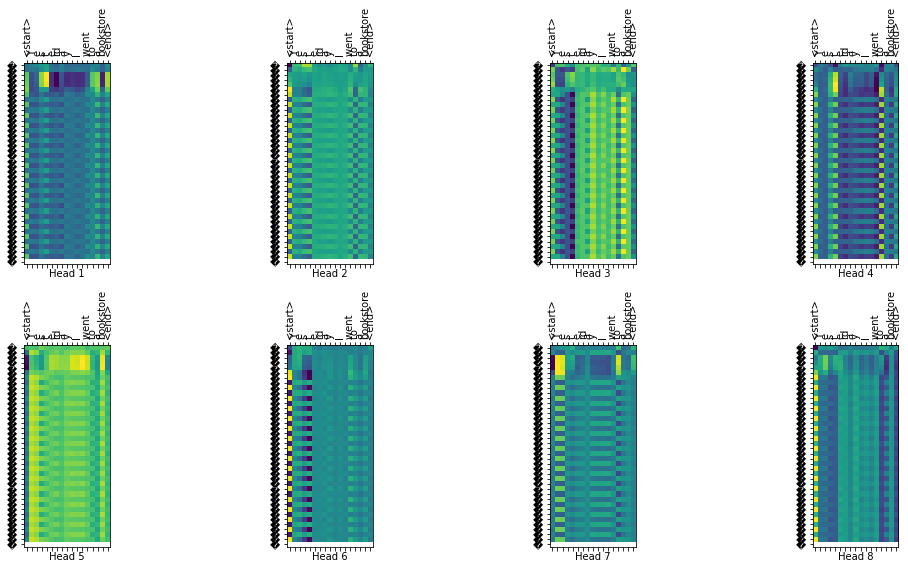

'匌��������������������'

In [89]:
translate("Yesterday I went to a bookstore",plot='decoder_layer4_block2')

In [90]:
translate("Yesterday I went to a bookstore")

Input: Yesterday I went to a bookstore
Predicted Translation: 匌��������������������


'匌��������������������'

In [92]:
translate("how are you?")

Input: how are you?
Predicted Translation: 非常感要要一切。


'非常感要要一切。'

In [75]:
# # feed the model with its previous output
# sentence = 'I am not crazy, my mother had me tested.'
# for _ in range(5):
#   sentence = chatbot(sentence)
#   print('')

Input: I am not crazy, my mother had me tested.
Predicted Response: i m not sure .

Input: i m not sure .
Predicted Response: i m not sure .

Input: i m not sure .
Predicted Response: i m not sure .

Input: i m not sure .
Predicted Response: i m not sure .

Input: i m not sure .
Predicted Response: i m not sure .



In [76]:
# # feed the model with its previous output
# sentence = 'Who are you?'
# for _ in range(5):
#   sentence = chatbot(sentence)
#   print('')

Input: Who are you?
Predicted Response: i m not sure .

Input: i m not sure .
Predicted Response: i m not sure .

Input: i m not sure .
Predicted Response: i m not sure .

Input: i m not sure .
Predicted Response: i m not sure .

Input: i m not sure .
Predicted Response: i m not sure .



In [94]:
transformer.save_weights('/weights/nmt_eng_to_chi_transformer_ckpt')

In [102]:
# # del en_val[36]
# # del chi_val[36]
# # del en_val[123]
# # del chi_val[123]
# del en_val[147]
# del chi_val[147]

In [103]:
pynlpir.open()
bleuplus = 0
i = 0

for en_, chi_ in zip(en_val,chi_val):
    print(i)
    predicted = translate(en_)
    two_ = pynlpir.segment(predicted, pos_tagging=False)
    one_ = pynlpir.segment(chi_, pos_tagging=False)
    print('Real Translation: {}'.format(chi_))
    bleu_ = bleu.sentence_bleu([one_], two_)
    print("BLEU Score: ", bleu_)
    print("----" *20)

    bleuplus += bleu_
    i += 1

0
Input: what would you do if you had ten thousand dollars ?
Predicted Translation: 你有给我結婚？
Real Translation: 如果你有一万美元，你想做什么呢？
BLEU Score:  3.775112189210336e-155
--------------------------------------------------------------------------------
1
Input: when i hear that song , i remember my younger days .
Predicted Translation: 當我，，，，，，，，，，，，，，，，，，，，，，，，，，，，，，，，，，，，，，，
Real Translation: 每次听到这首歌，都会让我回忆起自己年轻的时候。
BLEU Score:  8.561894227089738e-232
--------------------------------------------------------------------------------
2
Input: when was the last time you spent time on facebook ?
Predicted Translation: 你看的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的
Real Translation: 你上一次用Facebook是什麼時候？
BLEU Score:  7.199666163340923e-232
--------------------------------------------------------------------------------
3
Input: you are no better at remembering things than i am .
Predicted Translation: 你对個好于于于于于于于于于于于于于于于于于于于于于于于于于于于于于于于于于于于于于
Real Translation: 你记事情的能力并不比我好多少。
BLEU Score:  8.56189422708973

Input: everybody in the room was stunned by what happened .
Predicted Translation: 在箌����国国国国国国国国国国国国国国国国国国国国国国国国国国国国国国国国
Real Translation: 屋裡的每個人都被發生的事驚住了。
BLEU Score:  0
--------------------------------------------------------------------------------
32
Input: everyone except tom knew he didn t need to do that .
Predicted Translation: 汤姆知道玛丽，，，，，，，，，，，，，，，，，，，，，，，，，，，，，，，，，，，，，，，
Real Translation: 除了汤姆以外任何人都知道他没必要这么做。
BLEU Score:  8.510469113101058e-232
--------------------------------------------------------------------------------
33
Input: everyone ought to be the master of his own destiny .
Predicted Translation: 他的值得他的他的他的他的他的他的他的他的他的他的他的他的他的他的他的他的他的他的他的他的他的他的他的他的他的他的他的他的他的他的他的他的他的他的他的他的他的他的
Real Translation: 每個人都應該做自己命運的主人。
BLEU Score:  6.110848977001762e-232
--------------------------------------------------------------------------------
34
Input: for some reason the microphone didn t work earlier .
Predicted Translation: 不是所有綶�������
Real Translation: 剛才我的麥克風沒起作用，不知道為什麼。
BLEU

Input: i m disappointed that i wasn t able to go with her .
Predicted Translation: 我忍受看到信感到感到感到感到感到感到感到感到感到感到感到感到感到感到感到感到感到感到感到感到感到感到感到感到感到感到感到感到感到感到感到感到感到感到感到感到
Real Translation: 我很失望我沒能和她一起去。
BLEU Score:  7.244248269687037e-232
--------------------------------------------------------------------------------
62
Input: i m on my way to meet tom at the station right now .
Predicted Translation: 我在回湯姆。
Real Translation: 我现在在去车站见汤姆的路上。
BLEU Score:  7.865406450922293e-232
--------------------------------------------------------------------------------
63
Input: i ve been told that you re a very competent person .
Predicted Translation: 我觉得你以以以以以以以以以以以以以以以以以以以以以以以以以以以以以以以以以以以以以以以
Real Translation: 有人說你是個很有能力的人。
BLEU Score:  7.156422969333831e-232
--------------------------------------------------------------------------------
64
Input: i ve done bad things that i should be punished for .
Predicted Translation: 我做應該應該應該應該應該應該應該應該應該應該應該應該應該應該應該應該應該應該應該應該應該應該應該應該應該應該應該應該應該應該應該應該應該應該應該應該應該應該應該


Input: she twisted her ankle while she was doing exercise .
Predicted Translation: 她丈夫丈夫丈夫丈夫。
Real Translation: 她锻炼时扭伤了脚踝。
BLEU Score:  1.171778691554733e-231
--------------------------------------------------------------------------------
92
Input: she was at a loss for words to express her feeling .
Predicted Translation: 她她的減感到感到感到感到感到感到感到感到感到感到感到感到感到感到感到感到感到感到感到感到感到感到感到感到感到感到感到感到感到感到感到感到感到感到感到感到感到
Real Translation: 她已经无法用语言表达她的感觉了。
BLEU Score:  3.0849033871801486e-155
--------------------------------------------------------------------------------
93
Input: she wrote him a long letter , but he didn t read it .
Predicted Translation: 他他他他他他他他他他他他他他他他他他他他他他他他他他他他他他他他他他他他他他他他
Real Translation: 她给他写了一封长信，但是他没有看。
BLEU Score:  8.614911585158347e-232
--------------------------------------------------------------------------------
94
Input: stop getting yourself worked up over little things .
Predicted Translation: 常���。
Real Translation: 不要让自己因为一些小事而烦躁了。
BLEU Score:  0
-------------------

Input: tom says that mary definitely won t accept the job .
Predicted Translation: 在你，做做，，，，，，，，，，，，，，，，，，，，，，，，，，，，，，，，，，，，
Real Translation: 湯姆說瑪麗絕不會接受這工作。
BLEU Score:  0
--------------------------------------------------------------------------------
124
Input: tom told me that i shouldn t go out alone at night .
Predicted Translation: 汤姆3030澳大利亚。
Real Translation: 汤姆跟我说我不应该晚上一个人出门。
BLEU Score:  2.0732986305800918e-232
--------------------------------------------------------------------------------
125
Input: tom told me that he doesn t like carbonated drinks .
Predicted Translation: 他很少是否看見看見我的，着。
Real Translation: 汤姆告诉我他不喜欢碳酸饮料。
BLEU Score:  1.2627076138080564e-231
--------------------------------------------------------------------------------
126
Input: tom very often takes a nap for an hour after lunch .
Predicted Translation: 湯姆週週週月�
Real Translation: 汤姆很经常在午饭后小憩一小时。
BLEU Score:  0
--------------------------------------------------------------------------------
127
Input: tom 

Input: do you know which deity this temple is dedicated to ?
Predicted Translation: 你知道這個哪個哪個�
Real Translation: 您知道这座庙宇供奉的是哪个神吗？
BLEU Score:  7.536728468577135e-232
--------------------------------------------------------------------------------
155
Input: don t translate english into japanese word for word .
Predicted Translation: 不要不不不不不不不不不不不不不不不不不不不不不不不不不不不不不不不不不不不不不不不
Real Translation: 不要逐字逐句的把英文翻譯成日文。
BLEU Score:  0
--------------------------------------------------------------------------------
156
Input: everybody except tom knew he didn t need to do that .
Predicted Translation: 汤姆知道玛丽什么时候来。
Real Translation: 除了汤姆以外任何人都知道他没必要这么做。
BLEU Score:  7.216120604020078e-232
--------------------------------------------------------------------------------
157
Input: flies and mosquitoes interfered with his meditation .
Predicted Translation: 孩��。
Real Translation: 蒼蠅和蚊子干擾了他的冥想。
BLEU Score:  0
--------------------------------------------------------------------------------
158
Input: flu

Input: i m really sorry . i seem to have lost your umbrella .
Predicted Translation: 我很抱歉汤姆的汤姆的汤姆的汤姆的汤姆的汤姆的，汤姆的汤姆的汤姆的汤姆的汤姆的汤姆的汤姆的汤姆的汤姆的，汤姆的，汤姆的汤姆的汤姆的汤姆的汤姆的汤姆的汤姆的汤姆的汤姆的汤姆的汤姆的汤姆的汤姆的汤姆的汤姆的汤姆的汤姆的汤姆的汤姆的汤姆的
Real Translation: 我真的很抱歉，我好像弄丢了你的雨伞。
BLEU Score:  3.539808316679932e-155
--------------------------------------------------------------------------------
187
Input: i m very grateful for everything you ve done for me .
Predicted Translation: 我會盡樂感到相。
Real Translation: 非常感谢你所做的一切。
BLEU Score:  9.709385502639237e-232
--------------------------------------------------------------------------------
188
Input: i ve been wanting to see that movie for a long time .
Predicted Translation: 我在這裡已經時間了。
Real Translation: 我想看那电影想好久了。
BLEU Score:  6.373704167435469e-155
--------------------------------------------------------------------------------
189
Input: if i were invisible i wouldn t have to dress myself .
Predicted Translation: 我羚������������������������������������
Real Translation: 若我是隱形的，就不用

Input: that s the computer on which he writes his articles .
Predicted Translation: 他想篇篇篇篇比較的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的的
Real Translation: 那就是那台他用来写文章的电脑。
BLEU Score:  8.614911585158347e-232
--------------------------------------------------------------------------------
218
Input: that s the same story as i heard when i was a child .
Predicted Translation: 我是我是我是我是我是我是我是我是我是我是我是我是我是我是我是我是我是我是我是我是我是我是我是我是我是我是我是我是我是我是我是我是我是我是我是我是我是我是我是我是
Real Translation: 那跟當我是個孩子時所聽到的是同樣的故事。
BLEU Score:  2.2017766405070104e-155
--------------------------------------------------------------------------------
219
Input: the internet is an invaluable source of information .
Predicted Translation: 那錌���������看看看看看看看看看看看看看看看看看看看看
Real Translation: 互联网是一种无法估量的信息资源。
BLEU Score:  0
--------------------------------------------------------------------------------
220
Input: the bill was passed after a hard fight in the house .
Predicted Translation: 這��刈��。
Real Translation: 該法案在眾議院爭議後獲得通過。
BLEU Score:  0


Input: a foreign language can t be mastered in a year or so .
Predicted Translation: 盯著月月月月月月月月月月月月月月月月月月月月月月月月月月月月月月月月月月月月月月月
Real Translation: 一個外國語言無法在一年左右就被掌握。
BLEU Score:  0
--------------------------------------------------------------------------------
249
Input: a stay of execution was ordered at the eleventh hour .
Predicted Translation: 一踸�����。
Real Translation: 缓期执行在最后关头决定了下来。
BLEU Score:  0
--------------------------------------------------------------------------------
250
Input: after she had read the letter , she tore it to pieces .
Predicted Translation: 她記这这这这这这这这这这这这这这这这这这这这这这这这这这这这这这这这这这这这这这
Real Translation: 看了信之後，她把它撕成碎片。
BLEU Score:  7.244248269687037e-232
--------------------------------------------------------------------------------
251
Input: after walking for an hour , we stopped to take a rest .
Predicted Translation: 我們年年結婚。
Real Translation: 走了一個小時後，我們停下來休息。
BLEU Score:  2.2111230223300796e-155
-------------------------------------------------------------

Input: i m now rich enough to afford to get anything i want .
Predicted Translation: 我在找到多多多多多多多多多多多多多多多多多多多多多多多多多多多多多多多多多多多多多多
Real Translation: 我现在富得能买我想要的任何东西。
BLEU Score:  8.412065649527267e-232
--------------------------------------------------------------------------------
280
Input: if you have a question , please raise your right hand .
Predicted Translation: 如果你会让个，，，，，，，，，，，，，，，，，，，，，，，，，，，，，，，，，，，，，
Real Translation: 如果有问题，请举起你的右手。
BLEU Score:  9.418382295637229e-232
--------------------------------------------------------------------------------
281
Input: if you need my advice , i d be glad to give it to you .
Predicted Translation: 如果你需要幫你。
Real Translation: 如果你需要我的建议，我很愿意告诉你。
BLEU Score:  2.2614485705630703e-78
--------------------------------------------------------------------------------
282
Input: if you pass this test , you could graduate next month .
Predicted Translation: 如果你你有，，，，，，，，，，，，，，，，，，，，，，，，，，，，，，，，，，，，，，
Real Translation: 如果你通過這個考試，你下個月就可以畢業了。
BLEU Scor

Input: the bridge will be completed by the end of this year .
Predicted Translation: 這個人人人當當當當當當當當當當當當當當當當當當當當當當當當當當當當當當當當當當當當
Real Translation: 大橋將在年底完工。
BLEU Score:  0
--------------------------------------------------------------------------------
310
Input: the bus stopped suddenly in the middle of the street .
Predicted Translation: 䈈�������������������������������������
Real Translation: 公車突然在路中央停下來。
BLEU Score:  0
--------------------------------------------------------------------------------
311
Input: the girl was sobbing in the corner of the schoolroom .
Predicted Translation: 一個大大大大大大大大大大大大大大大大大大大大大大大大大大大大大大大大大大大大大大大
Real Translation: 女孩在教室的角落啜泣。
BLEU Score:  0
--------------------------------------------------------------------------------
312
Input: the hallway needs to be wide enough for a wheelchair .
Predicted Translation: 把把鈈�����������������������������������
Real Translation: 走廊要寬得能容下輪椅。
BLEU Score:  0
----------------------------------------------------------------

Input: what is learned in the cradle is carried to the tomb .
Predicted Translation: 湯姆在宮�什么什么。
Real Translation: 幼年時學的東西，一輩子不會忘記。
BLEU Score:  3.571883312829026e-232
--------------------------------------------------------------------------------
341
Input: whether he comes or not , the result will be the same .
Predicted Translation: 他說，，，，，，，，，，，，，，，，，，，，，，，，，，，，，，，，，，，，，，，
Real Translation: 他来还是不来，结果是一样的。
BLEU Score:  8.561894227089738e-232
--------------------------------------------------------------------------------
342
Input: whichever route you take , you will get there in time .
Predicted Translation: 如果你將花將花將花較較，，，，，，，，，，，，，，，，，，，，，，，，，，，，，，，，，，
Real Translation: 不管你选哪条路，你都能按时到那里。
BLEU Score:  8.412065649527267e-232
--------------------------------------------------------------------------------
343
Input: why have you been late to school every day this week ?
Predicted Translation: 今天早上遲到了？
Real Translation: 為什麼你這個禮拜每天上學都遲到？
BLEU Score:  1.871675229887314e-155
------------

Input: i didn t know who was going to meet me at the airport .
Predicted Translation: 我不知道住在哪裡。
Real Translation: 我不知道谁会在机场见我。
BLEU Score:  3.950732890998763e-78
--------------------------------------------------------------------------------
372
Input: i just wanted to prove to myself that i could do this .
Predicted Translation: 我会为你为你为你付錢。
Real Translation: 我只想向自己证明我可以做到。
BLEU Score:  1.1896457329133973e-231
--------------------------------------------------------------------------------
373
Input: i think i now have enough money to buy the car i want .
Predicted Translation: 我必須買東西地方地方地方地方地方地方地方。
Real Translation: 我认为我现在有足够的钱买我想要的那辆车。
BLEU Score:  9.040047455305228e-232
--------------------------------------------------------------------------------
374
Input: i took him to the most expensive restaurant on campus .
Predicted Translation: 我在週週週一一一一一一一一一一一一一一一一一一一一一一一一一一一一一一一一一一一一
Real Translation: 我把他带到校区里最贵的餐馆去了。
BLEU Score:  8.319100378795605e-232
---------------------------------

Input: philosophy is not a thing one can learn in six months .
Predicted Translation: 日本日本日本日本日本日本的日本的。
Real Translation: 哲学不是我们用六个月就能学的东西。
BLEU Score:  8.166726842395623e-232
--------------------------------------------------------------------------------
403
Input: please bring us two cups of tea and one cup of coffee .
Predicted Translation: 請給我們們們們們們們們們們們們們們們們們們們們們們們們們們們們們們們們們們們們們們們
Real Translation: 请来两杯茶和一杯咖啡。
BLEU Score:  0
--------------------------------------------------------------------------------
404
Input: please have a seat and wait until your name is called .
Predicted Translation: 請快點，，，，，，，，，，，，，，，，，，，，，，，，，，，，，，，，，，，，，，
Real Translation: 请在被叫到名字之前坐在椅子上等候。
BLEU Score:  0
--------------------------------------------------------------------------------
405
Input: please replace the empty ink cartridge in the printer .
Predicted Translation: 請們們們們們們們們們們們們們們們們們們們們們們們們們們們們們們們們們們們們們們們
Real Translation: 请把打印机里面的空的墨粉鼓换掉。
BLEU Score:  0
---------------------------------------

Input: were you able to do everything you wanted to get done ?
Predicted Translation: 你做做做做做做吗？
Real Translation: 你是不是有能力做到你想要完成的所有事情呢？
BLEU Score:  2.614591671051252e-232
--------------------------------------------------------------------------------
434
Input: when i first came back to boston , i was really lonely .
Predicted Translation: 當我，，，，，，，，，，，，，，，，，，，，，，，，，，，，，，，，，，，，，，，
Real Translation: 当我第一次回波士顿时，我真是孤独。
BLEU Score:  8.561894227089738e-232
--------------------------------------------------------------------------------
435
Input: who is in charge of the office while the boss is away ?
Predicted Translation: 誰负责？
Real Translation: 在主任不在的时候，办公室由谁来负责？
BLEU Score:  4.0433713454986733e-156
--------------------------------------------------------------------------------
436
Input: why don t you wait here while i finish what i m doing ?
Predicted Translation: 您想來這裡，知道，知道，知道，知道，知道，知道，知道，知道，知道，，，，，，，，，，，，，，，，，，，，
Real Translation: 为什么你不在这里等到我做完为止？
BLEU Score:  0
------------------

Input: germany adopted a social security system in the s .
Predicted Translation: 這刈������������������������������������
Real Translation: 德国在1880年代采取了一种社会保障制度。
BLEU Score:  0
--------------------------------------------------------------------------------
465
Input: he doesn t have any knowledge about american democracy .
Predicted Translation: 他未沒有男孩。
Real Translation: 他一点都不知道美国的民主。
BLEU Score:  8.396161215621529e-232
--------------------------------------------------------------------------------
466
Input: he doesn t know the difference between right and wrong .
Predicted Translation: 他不知道，，，，，，，，，，，，，，，，，，，，，，，，，，，，，，，，，，，，，，，
Real Translation: 他好坏不分。
BLEU Score:  8.510469113101058e-232
--------------------------------------------------------------------------------
467
Input: he went on reading the book as if nothing had happened .
Predicted Translation: 他周周周錯誤。
Real Translation: 他繼續讀書，好像什麼事也沒有發生。
BLEU Score:  3.682245099646241e-232
-----------------------------------------------

Input: kissing a person who smokes is like licking an ashtray .
Predicted Translation: 鴴�������������������������������������
Real Translation: 亲吻一个抽烟的人就像在舔烟灰缸。
BLEU Score:  0
--------------------------------------------------------------------------------
495
Input: lake baikal in russia is the deepest lake in the world .
Predicted Translation: 柟�����
Real Translation: 在俄羅斯的貝加爾湖是世界上最深的湖泊。
BLEU Score:  0
--------------------------------------------------------------------------------
496
Input: lake baikal in russia is the deepest lake in the world .
Predicted Translation: 柟�����
Real Translation: 俄羅斯的貝加爾湖是世界上最深的湖泊。
BLEU Score:  0
--------------------------------------------------------------------------------


In [104]:
# bleuplus = 0

# for ques_, ans_ in zip(questions_val,answers_val):
#     predicted = chatbot(ques_)
#     print('Real Response: {}'.format(ans_))
#     bleu_ = bleu.sentence_bleu([ans_.split()], predicted.split())
#     print("BLEU Score: ", bleu_)
#     print("----" *20)

#     bleuplus += bleu_

In [105]:
bleuplus/len(en_val)

0.00011631466884973117

Input: how are you?
Predicted Translation: 非常感要要一切。


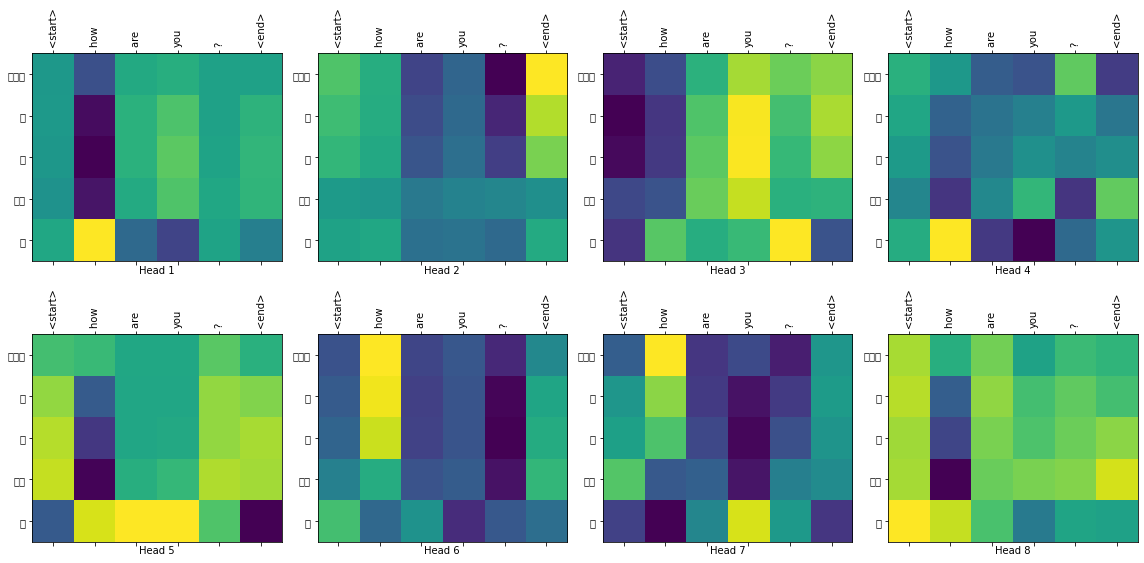

'非常感要要一切。'

In [110]:
translate("how are you?",plot='decoder_layer4_block2')

In [108]:
transformer.save_weights('/weights/nmt_eng_to_chi_transformer_ckpt')

In [109]:
translate('did you finish your homework?')

Input: did you finish your homework?
Predicted Translation: 你你该你的你的你的你的你的你的你的你的你的你的你的你的你的你的你的你的你的你的你的你的你的你的你的你的你的你的你的你的你的你的你的你的你的你的你的你的你的你的


'你你该你的你的你的你的你的你的你的你的你的你的你的你的你的你的你的你的你的你的你的你的你的你的你的你的你的你的你的你的你的你的你的你的你的你的你的你的你的你的'

In [111]:
translate('what did you eat for breakfast?')

Input: what did you eat for breakfast?
Predicted Translation: 我们有餐三明治。


'我们有餐三明治。'

In [112]:
translate('how are you doing?')

Input: how are you doing?
Predicted Translation: 你做如何如何如何如何。


'你做如何如何如何如何。'

In [113]:
translate("What's your name?")

Input: What's your name?
Predicted Translation: 你�了你的了你的了你的了你的了你的了你的了你的了你的了你的了你的了你的了你的了你的了你的了你的了你的了你的了你的了你的了你的了你的了你的了你的了你的了你的了你的了你的了你的了你的了你的了你的了你的了你的了你的了你的了你的了你的


'你�了你的了你的了你的了你的了你的了你的了你的了你的了你的了你的了你的了你的了你的了你的了你的了你的了你的了你的了你的了你的了你的了你的了你的了你的了你的了你的了你的了你的了你的了你的了你的了你的了你的了你的了你的了你的了你的'

In [114]:
translate("I am hungry right now")

Input: I am hungry right now
Predicted Translation: 䜜���。


'䜜���。'

In [116]:
translate("I am full")

Input: I am full
Predicted Translation: ��������������������


'��������������������'

In [117]:
translate('How are you?')

Input: How are you?
Predicted Translation: 你的涌�������


'你的涌�������'

In [118]:
translate('Where are you going?')

Input: Where are you going?
Predicted Translation: 你應該必要必要就就就就就就就就就就就就就就就就就就就就就就就就就就就就就就就就就就就就就


'你應該必要必要就就就就就就就就就就就就就就就就就就就就就就就就就就就就就就就就就就就就就'

In [119]:
translate('Nice to meet you')

Input: Nice to meet you
Predicted Translation: 你會�你。


'你會�你。'

In [120]:
translate("I love you")

Input: I love you
Predicted Translation: 你�愛你。


'你�愛你。'